In [31]:
#Import TensorFlow and other libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [32]:
#Download and explore the dataset

'''
dataset/
  circle/
  rectangle/
  square/
  triangle/

'''

import pathlib

data_dir = pathlib.Path('dataset')

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)



2005


In [33]:
circles = list(data_dir.glob('circle/*'))
PIL.Image.open(str(circles[0]))


In [46]:
#Load using keras.preprocessing

#Create a dataset
#Define some parameters for the loader:

batch_size = 4
img_height = 28
img_width = 28

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 80% of the images for training, and 20% for validation
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2005 files belonging to 4 classes.
Using 1604 files for training.


In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2005 files belonging to 4 classes.
Using 401 files for validation.


In [48]:
class_names = train_ds.class_names
print(class_names)


['circle', 'rectangle', 'square', 'triangle']


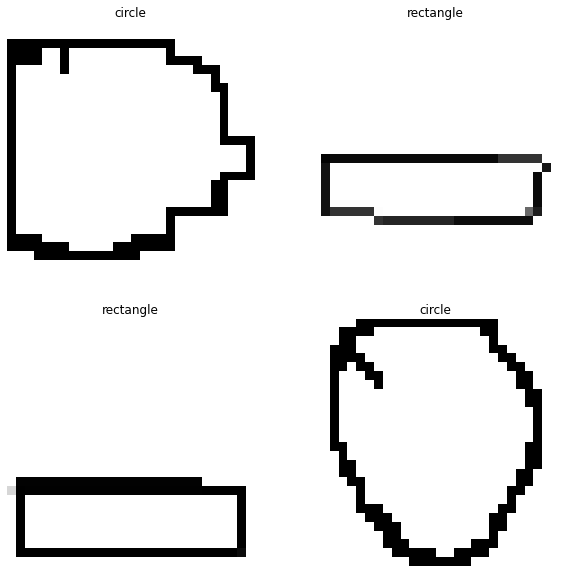

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [50]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(4, 28, 28, 3)
(4,)


In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [52]:
'''
Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.
'''
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)



In [53]:
#There are two ways to use this layer. You can apply it to the dataset by calling map:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.14117648 1.0


In [54]:
'''
Or, you can include the layer inside your model definition, which can simplify deployment. We will use the second approach here.
'''


'\nOr, you can include the layer inside your model definition, which can simplify deployment. We will use the second approach here.\n'

In [55]:
#Create the model
'''
The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 
'''
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [56]:
#Compile the model
'''
For this tutorial, choose the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.
'''
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [57]:
#Model summary
#View all the layers of the network using the model's summary method:
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)         

In [58]:
#Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
401/401 [==============================] - 2s 3ms/step - loss: 1.0382 - accuracy: 0.5380 - val_loss: 0.4744 - val_accuracy: 0.8504
Epoch 2/10
401/401 [==============================] - 1s 3ms/step - loss: 0.3087 - accuracy: 0.9020 - val_loss: 0.3092 - val_accuracy: 0.8753
Epoch 3/10
401/401 [==============================] - 1s 3ms/step - loss: 0.1729 - accuracy: 0.9382 - val_loss: 0.2922 - val_accuracy: 0.8953
Epoch 4/10
401/401 [==============================] - 1s 3ms/step - loss: 0.0864 - accuracy: 0.9729 - val_loss: 0.4472 - val_accuracy: 0.9102
Epoch 5/10
401/401 [==============================] - 1s 3ms/step - loss: 0.1138 - accuracy: 0.9623 - val_loss: 0.3100 - val_accuracy: 0.9277
Epoch 6/10
401/401 [==============================] - 1s 3ms/step - loss: 0.0553 - accuracy: 0.9817 - val_loss: 0.1918 - val_accuracy: 0.9451
Epoch 7/10
401/401 [==============================] - 1s 3ms/step - loss: 0.0413 - accuracy: 0.9810 - val_loss: 0.1929 - val_accuracy: 0.9526
Epoch 

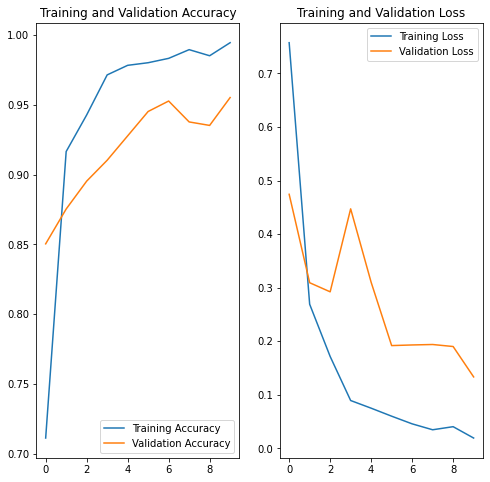

In [59]:
#Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [18]:
#Predict on new data
'''
Finally, let's use our model to classify an image that wasn't included in the training or validation sets.
'''
#prediction_dir = "/home/shahir/Documents/4-2/Pattern Lab/Project/dataset/shapedetectorproject/main/predictiondata/1.png"
prediction_path = "/home/shahir/Documents/4-2/Pattern Lab/Project/dataset/shapedetectorproject/main/predictiondata/7.png"

img = keras.preprocessing.image.load_img(
    prediction_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to rectangle with a 79.42 percent confidence.


In [19]:
#Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


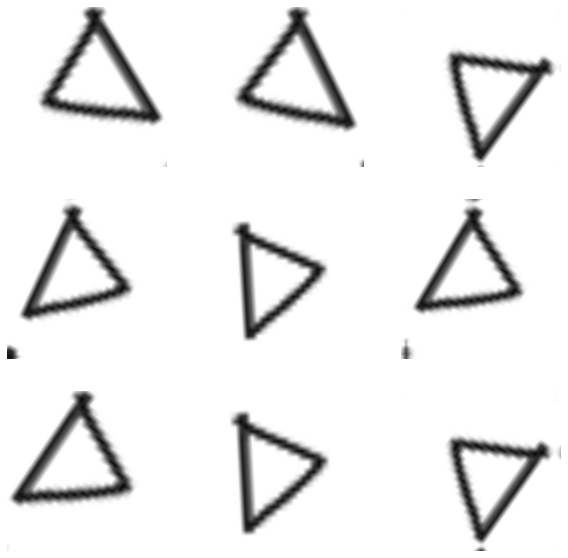

In [20]:
#Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [21]:
'''
Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.
'''
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [22]:
#Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [23]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
401/401 [==============================] - 23s 56ms/step - loss: 1.3458 - accuracy: 0.3471 - val_loss: 0.9290 - val_accuracy: 0.6309
Epoch 2/15
401/401 [==============================] - 22s 56ms/step - loss: 0.8790 - accuracy: 0.6470 - val_loss: 0.7275 - val_accuracy: 0.6833
Epoch 3/15
401/401 [==============================] - 22s 56ms/step - loss: 0.6859 - accuracy: 0.7280 - val_loss: 0.6068 - val_accuracy: 0.7182
Epoch 4/15
401/401 [==============================] - 22s 56ms/step - loss: 0.6198 - accuracy: 0.7558 - val_loss: 0.5249 - val_accuracy: 0.7905
Epoch 5/15
401/401 [==============================] - 23s 57ms/step - loss: 0.5091 - accuracy: 0.7994 - val_loss: 0.4395 - val_accuracy: 0.8130
Epoch 6/15
401/401 [==============================] - 22s 56ms/step - loss: 0.4388 - accuracy: 0.8258 - val_loss: 0.4421 - val_accuracy: 0.8204
Epoch 7/15
401/401 [==============================] - 22s 56ms/step - loss: 0.3580 - accuracy: 0.8610 - val_loss: 0.4213 - val_accuracy:

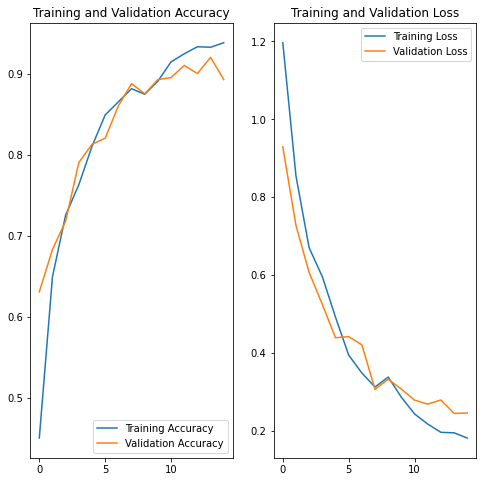

In [25]:
#Visualize training results
#After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [26]:
def predict_shape(img_path):
    img = keras.preprocessing.image.load_img(
    prediction_path, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
  

In [27]:
#Predict on new data testing
'''
Finally, let's use our model to classify an image that wasn't included in the training or validation sets.
'''
#prediction_dir = "/home/shahir/Documents/4-2/Pattern Lab/Project/dataset/shapedetectorproject/main/predictiondata/1.png"
prediction_path = "/home/shahir/Documents/4-2/Pattern Lab/Project/dataset/shapedetectorproject/main/predictiondata/7.png"

predict_shape(prediction_path)

This image most likely belongs to square with a 67.53 percent confidence.


In [28]:
#saving model in HDF5 format


# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('shapedetector_model.h5') 
#model.save('shapedetector_model_2.h5') 
#model.save('shapedetector_model_3.h5')
#model.save('shapedetector_model_4.h5')
#model.save('shapedetector_model_5.h5')
#model.save('shapedetector_model_4b.h5')
model.save('shapedetector_model_4c.h5')

In [29]:
#recreating the model from shapedetector_model

#shapedetector_model = tf.keras.models.load_model('shapedetector_model.h5')
#shapedetector_model_2 = tf.keras.models.load_model('shapedetector_model_2.h5')
#shapedetector_model_3 = tf.keras.models.load_model('shapedetector_model_3.h5')
#shapedetector_model_4 = tf.keras.models.load_model('shapedetector_model_4.h5')
#shapedetector_model_5 = tf.keras.models.load_model('shapedetector_model_5.h5')
#shapedetector_model_4b = tf.keras.models.load_model('shapedetector_model_4b.h5')
shapedetector_model_4c = tf.keras.models.load_model('shapedetector_model_4c.h5')
#show the model architecture 
#shapedetector_model_2.summary()
#shapedetector_model_3.summary()
#shapedetector_model_4.summary()
#shapedetector_model_5.summary()
#shapedetector_model_4b.summary()
shapedetector_model_4c.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [30]:
#checking the accuracy of the loaded model
prediction_path = "/home/shahir/Documents/4-2/Pattern Lab/Project/dataset/shapedetectorproject/main/predictiondata/drawn.png"
img = keras.preprocessing.image.load_img(
prediction_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#push the image to the model
predictions = shapedetector_model_4c.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
"This image most likely belongs to {} with a {:.2f} percent confidence."
.format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to square with a 61.76 percent confidence.


In [34]:
#Gui 

import tkinter as tk
from PIL import ImageTk, Image
from tkinter import filedialog

def load_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()

    image_data = filedialog.askopenfilename(initialdir="predictiondata", title="Choose an image",
                                       filetypes=(("all files", "*.*"), ("png files", "*.png")))
    
    basewidth = 300
    img = Image.open(image_data)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    file_name = image_data.split('/')
    panel = tk.Label(frame, text= str(file_name[len(file_name)-1]).upper()).pack()
    panel_image = tk.Label(frame, image=img).pack()


    
def classify():
    img = keras.preprocessing.image.load_img(
    image_data, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    label = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
    table = tk.Label(frame, text="Top image class predictions and confidences").pack()
    result = tk.Label(frame,text= label).pack()



root = tk.Tk()
root.title('Shape Detector')

root.resizable(False, False)
tit = tk.Label(root, text="Shape Detector", padx=25, pady=6, font=("", 12)).pack()
canvas = tk.Canvas(root, height=500, width=500, bg='grey')
canvas.pack()
frame = tk.Frame(root, bg='white')
frame.place(relwidth=0.8, relheight=0.8, relx=0.1, rely=0.1)
chose_image = tk.Button(root, text='Choose Image',
                        padx=35, pady=10,
                        fg="white", bg="grey", command=load_img)
chose_image.pack(side=tk.LEFT)
class_image = tk.Button(root, text='Classify Image',
                        padx=35, pady=10,
                        fg="white", bg="grey", command=classify)
class_image.pack(side=tk.RIGHT)

root.mainloop()